# How to implement testing for Covid-19

This notebook shows you how to implement testing in your model and demonstrates how the spread of the disease can change if people change their behavior due to the information.

Testing has proven to be a key counter measure to the Covid-19 epidemy. It is necessary to gain information on people's health statuses and to change their behavior or the behavior of their recent contacts. The goal is to interrupt a chain of infections early on and prevent superspreaders or exponential increases in infection numbers.

Testing also enables to study a multitude of new scenarios which can be helpful for policy makers to enact interventions to get the disease under control.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sid import get_simulate_func
from sid.config import INDEX_NAMES
from sid.shared import get_epidemiological_parameters

## The stages

Testing is implemented in three stages to offer full flexibility for researchers to implement different testing schemes. We will go through each stage in detail. To summarise, the three stages are

- Calculating the demand for tests.
- Allocating tests to individuals.
- Processing tests in laboratories.

### Demand models

In the first stage, the demand for tests is calculated. The user can specify multiple demand models where each model represents a channel through which an individual can ask for a test. An individual can request a test if she is symptomatic, if she works with elderly people, or if she has the potential to be a superspreader (e.g. teachers).

Each model is a dictionary similar to a contact model. It has the following keys:

- A ``"loc"`` entry subsets the parameters passed to the function to facilitate access.
- ``"start"`` and ``"end"`` are dates which can be parsed with :func:`pandas.Timestamp` and represent the period in which the testing model is active.
- Under the ``"model"`` key is a function which assigns a probability to each individual which is the likelihood by which the person demands a test. Below, you find an example for an demand model where individuals ask for a test when they experience symptoms, have not already received a positive test result and when they are not waiting for a test result. The return of the demand model can be a :class:`pandas.Series` or :class:`numpy.ndarray`.

In [2]:
def demand_test_if_experience_symptoms(states, params):
    """Demand test if person experiences symptoms.

    This demand model assumes that individuals request a test for a
    Covid-19 infection if they experience symptoms, have not requested
    a test before which is still pending and have not received a positive
    test result with a probability of 1.

    Args:
        states (pandas.DataFrame): The states of the individuals.
        params (pandas.DataFrame): A DataFrame with parameters.

    Returns:
        demand_probability (numpy.ndarray, pandas.Series): An array or a series
            which contains the probability for each individual demanding a test.

    """
    s = states.symptomatic & ~states.pending_test & ~states.knows_immune
    return s

In [3]:
testing_demand_models = {
    "symptoms": {
        "model": demand_test_if_experience_symptoms,
        # "loc": ...,
        # "start": "2019-02-29",
        # "end": pd.Timestamp("2019-07-30"),
    }
}

### Allocation models

In the second phase, available tests are distributed to individuals with allocation models. If an individual is assigned a test, the test will be administered and is ready to be processed by an laboratory in the next stage.

Allocation models have to purposes: First, they allow to resolve instances in which the demand for tests exceeds the available number of tests which is given by

```python
params.loc[("testing", "allocation", "rel_available_tests"), "value"]
```

per 100,000 individuals.

If allocation models assign more tests than are available, a warning is issued, but the simulation continues. A warning is also raised, if an individual receives multiple tests.

Secondly, allocation models allow to give some groups preferred access to tests. For example, policy makers may decide that health care workers, teachers or other professions have a higher priority.

Allocations models are similarly defined as demand models. Inside sid, we loop over all custom allocation models which can return a boolean series indicating individuals which received a test. When a model returns a series with allocated tests, ``demands_test`` is set to ``False`` for individuals who have received a test. The following allocation model receives the updated ``demands_test`` and a new count of all individuals already receiving a test in this period which can be used to limit the allocation.

The second argument is ``demands_test`` which is a series indicating individuals who demand a test.

In [4]:
def allocate_tests(n_allocated_tests, demands_test, states, params):
    """Allocate tests to individuals who demand a test.

    For simplicity, we assume that everyone has the same chance of
    receiving a test to resolve excess demand.

    Args:
        n_allocated_tests (int): The number of individuals who already
            received a test in this period from previous allocation models.
        demands_test (pandas.Series): A series with boolean entries
            where ``True`` indicates individuals asking for a test.
        states (pandas.DataFrame): The states of the individuals.
        params (pandas.DataFrame): A DataFrame with parameters.

    Returns:
        allocated_tests (numpy.ndarray, pandas.Series): An array or a
            series which indicates which individuals received a test.

    """
    n_available_tests = int(
        params.loc[("testing", "allocation", "rel_available_tests"), "value"]
        * len(states)
        / 100_000
    )
    locs = states.loc[demands_test].sample(frac=1).index[:n_available_tests]

    allocated_tests = pd.Series(index=states.index, data=False)
    allocated_tests.loc[locs] = True

    return allocated_tests

In [5]:
testing_allocation_models = {"direct_allocation": {"model": allocate_tests}}

### Processing models

Now, we are in the third and final stage of the testing module. Here, all administered tests are collected and assigned to laboratories which will return the test result after some duration. With the test result, individuals are able to adjust their behavior or institutions can regulate behavior.

The processing models have two purposes similar to allocation models. First, they allow to resolve instances in which the demand for tests exceeds the available number of tests which is given by

```python
params.loc[("testing", "processing", "rel_available_capacity"), "value"]
```

per 100,000 individuals.

If processing models evaluate more test than they are capable of, a warning is issued, but the simulation continues.

Secondly, processing models allow to assign a higher priority to some tests. For example, if laboratories are not able to handle the flood of administered tests anymore, policy makers may decide that laboratories should prioritize newly administered tests to give feedback more quickly (last-in first-out principle).

Similarly, to the functions of allocation models, processing models receive a count called ``n_to_be_processed_tests`` which represents the number individuals whose test has already started to be processed. The individuals who administered a test which is waiting to be processed are indicated via ``states["pending_test"]``. Whenever an processing model returned a boolean series indicating individuals whose test is processed, ``states["pending_test"]`` is set to ``False`` for those individuals and ``n_to_be_processed_tests`` is updated.

In [6]:
def process_tests(n_to_be_processed_tests, states, params):
    """Process tests.

    For simplicity, we assume that all tests are processed immediately, without
    further delay.

    Args:
        n_to_be_processed_tests (int): Number of individuals whose test is
            already set to be processed.
        states (pandas.DataFrame): The states of the individuals.
        params (pandas.DataFrame): A DataFrame with parameters.

    Returns:
        started_processing (numpy.ndarray, pandas.Series): An array or series
            with boolean entries indicating which tests started to be processed.

    """
    n_available_capacity = int(
        params.loc[("testing", "processing", "rel_available_capacity"), "value"]
        * len(states)
        / 100_000
    )
    locs = states.loc[states.pending_test].sample(frac=1).index[:n_available_capacity]

    to_be_processed_tests = pd.Series(index=states.index, data=False)
    to_be_processed_tests.loc[locs] = True

    return to_be_processed_tests

In [7]:
testing_processing_models = {"direct_processing": {"model": process_tests}}

## Parameters

As seen before, sid requires two parameter values to set the number of available tests and the number of tests which can be processed by laboratories each day.

```python
params.loc[("testing", "allocation", "rel_available_tests"), "value"]
params.loc[("testing", "processing", "rel_available_capacity"), "value"]
```

<div class="alert alert-info">

If you require a more flexible parametrisation, e.g., resources are changing daily, set the parameters very high (e.g., 999,999,999) to avoid getting any warnings. Then, implement your allocation models and processing models such that they have access to the data on resources. For example, use :func:`functools.partial` in contrast to side-effects.
    
</div>

## Countdowns

Testing requires some new countdowns which are explained here.

- ``cd_received_test_result_true`` can be used to set the processing duration of the test.
- ``cd_knows_immune_false`` and ``cd_knows_infectious_false`` are countdowns which are started when an individual receives a positive test result and at whose end the individual does not know about her health status anymore. The state variables ``knows_immune`` and ``knows_infectious`` can be used to change the behaviour of individuals in contact models.

## Prepare the rest

To compare a model without testing with the same model with testing, we need to prepare some other objects.

### Initial states

In [8]:
available_ages = [
    "0-9",
    "10-19",
    "20-29",
    "30-39",
    "40-49",
    "50-59",
    "60-69",
    "70-79",
    "80-100",
]

ages = np.random.choice(available_ages, size=10_000)
regions = np.random.choice(["North", "South"], size=10_000)
households = np.random.choice(5_000, size=10_000)

initial_states = pd.DataFrame(
    {"age_group": ages, "region": regions, "household": households}
)
initial_states = initial_states.astype("category")
initial_states["id"] = initial_states.index

### Initial infections

Initial infections are specified via the initial conditions. We start the simulation with 100 infected individuals.

In [9]:
initial_conditions = {"initial_infections": 100}

### Contact models

The model has three contact models for households (recurrent), close and distant contacts. We assume that a complete household will stay at home if any member of the household received a positive test result for at least 14 days or until the person is no longer infectious.

In [10]:
def _if_hh_member_tested_positive_hh_stays_home(contacts, states):
    # Everyone who received a positive test result will stay home for 14 days
    # after the infection.
    condition = states.knows_immune & (
        states.cd_ever_infected.ge(-13) | states.knows_infectious
    )

    # Everyone who is in a household with someone
    # who has been tested positive will stay at home.
    household_level_condition = condition.groupby(states.household).transform(any)

    contacts.loc[household_level_condition] = 0

    return contacts


def meet_distant(states, params):
    possible_nr_contacts = np.arange(2)
    contacts = np.random.choice(possible_nr_contacts, size=len(states))
    contacts = pd.Series(contacts, index=states.index)

    contacts = _if_hh_member_tested_positive_hh_stays_home(contacts, states)

    return contacts


def meet_close(states, params):
    possible_nr_contacts = np.arange(3)
    contacts = np.random.choice(possible_nr_contacts, size=len(states))
    contacts = pd.Series(contacts, index=states.index)

    contacts = _if_hh_member_tested_positive_hh_stays_home(contacts, states)

    return contacts


def meet_household(states, params):
    # everyone always meets their household members.
    return pd.Series(1, states.index)


assort_by = ["age_group", "region"]

contact_models = {
    "household": {
        "model": meet_household,
        "assort_by": "household",
        "is_recurrent": True,
    },
    "close": {"model": meet_close, "assort_by": assort_by, "is_recurrent": False},
    "distant": {"model": meet_distant, "assort_by": assort_by, "is_recurrent": False},
}

### Parameters

In [11]:
inf_params = pd.read_csv("infection_probs.csv", index_col=INDEX_NAMES)
assort_probs = pd.read_csv("assort_by_params.csv", index_col=INDEX_NAMES)
disease_params = get_epidemiological_parameters()
params = pd.concat([disease_params, inf_params, assort_probs])

In [12]:
params.loc[("testing", "allocation", "rel_available_tests"), "value"] = 300
params.loc[("testing", "processing", "rel_available_capacity"), "value"] = 250

C:\tools\miniconda3\envs\sid\lib\site-packages\IPython\core\interactiveshell.py:2877: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = self._run_cell(


## Run the simulation

In [13]:
run_simulation_with_testing = get_simulate_func(
    params=params,
    initial_states=initial_states,
    initial_conditions=initial_conditions,
    contact_models=contact_models,
    duration={"start": "2020-02-27", "periods": 500},
    testing_demand_models=testing_demand_models,
    testing_allocation_models=testing_allocation_models,
    testing_processing_models=testing_processing_models,
    saved_columns={"testing_states": "pending_test"},
    seed=0,
    path=".sid_with_testing",
)
df_with_testing = run_simulation_with_testing(params=params)

In [14]:
run_simulation_without_testing = get_simulate_func(
    params=params,
    initial_states=initial_states,
    initial_conditions=initial_conditions,
    contact_models=contact_models,
    duration={"start": "2020-02-27", "periods": 500},
    saved_columns={"testing_states": "pending_test"},
    seed=0,
    path=".sid_without_testing",
)

df_without_testing = run_simulation_without_testing(params=params)

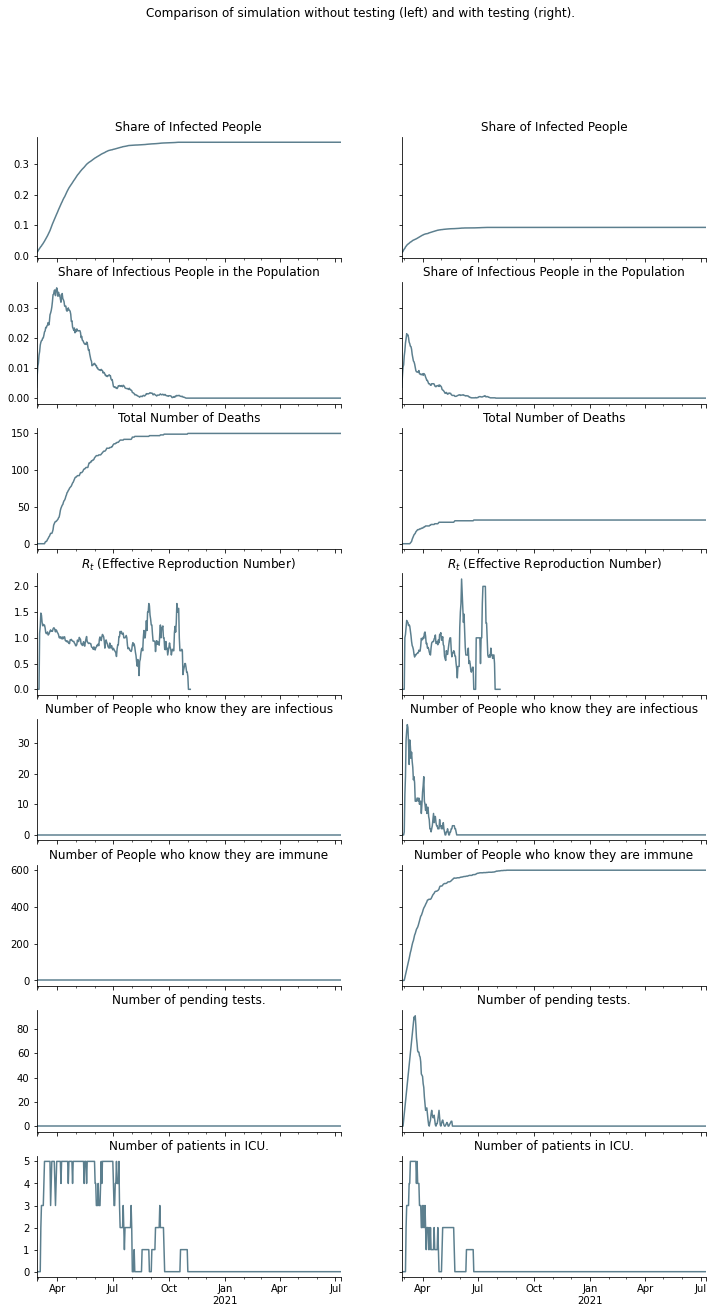

In [15]:
fig, axs = plt.subplots(8, 2, figsize=(12, 18), sharey="row", sharex=True)
fig.subplots_adjust(bottom=0, wspace=0.2, hspace=0.2)
fig.suptitle(
    "Comparison of simulation without testing (left) and with testing (right)."
)

for i, df in enumerate([df_without_testing, df_with_testing]):
    df = df.compute()

    df.resample("D", on="date")["ever_infected"].mean().plot(
        ax=axs[0, i], color="#5c7f8e"
    )
    df.resample("D", on="date")["infectious"].mean().plot(ax=axs[1, i], color="#5c7f8e")
    df.resample("D", on="date")["dead"].sum().plot(ax=axs[2, i], color="#5c7f8e")
    infectious_last_seven_days = df.cd_infectious_false.between(-7, 0)
    df.loc[infectious_last_seven_days].resample("D", on="date")[
        "n_has_infected"
    ].mean().plot(ax=axs[3, i], color="#5c7f8e")
    df.resample("D", on="date")["knows_infectious"].sum().plot(
        ax=axs[4, i], color="#5c7f8e"
    )
    df.resample("D", on="date")["knows_immune"].sum().plot(
        ax=axs[5, i], color="#5c7f8e"
    )
    df.resample("D", on="date")["pending_test"].sum().plot(
        ax=axs[6, i], color="#5c7f8e"
    )
    df.resample("D", on="date")["needs_icu"].sum().plot(ax=axs[7, i], color="#5c7f8e")

for ax in axs.flatten():
    ax.set_xlabel("")
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

for i in range(2):
    axs[0, i].set_title("Share of Infected People")
    axs[1, i].set_title("Share of Infectious People in the Population")
    axs[2, i].set_title("Total Number of Deaths")
    axs[3, i].set_title("$R_t$ (Effective Reproduction Number)")
    axs[4, i].set_title("Number of People who know they are infectious")
    axs[5, i].set_title("Number of People who know they are immune")
    axs[6, i].set_title("Number of pending tests.")
    axs[7, i].set_title("Number of patients in ICU.")

plt.show()